In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import os
import sys
sys.path.append('../src')
from skew import *

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
import pickle

data_dir = '../data/house-prices-advanced-regression-techniques'

In [14]:
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
params_xgb = {'subsample': 0.6,
              'learning_rate': 0.01,
              'min_child_weight': 5,
              'colsample_bytree': 0.7,
              'objective': 'reg:squarederror',
              'n_estimators': 1000,
              'max_depth': 5}

# Unskewed, normalized, encoded, feature selection on continuous columns only after encoding

In [16]:
target = 'SalePrice'
mockup_skew = SkewAnalysis()

nan, processed = mockup_skew.handle_nan(df.copy(), target)
unskew, tr = mockup_skew.unskew(processed)
normedEncoded = mockup_skew.normalize_and_encode(unskew)
focus_col = [i for i in df.columns if df.loc[:,i].dtype!='object']
feature = mockup_skew.feature_selection(normedEncoded, focus_col)

feature.head()

Following columns were remove because they contain more than 50% of Nan values : ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice,x0_C (all),x0_FV,x0_RH,x0_RL,x0_RM,x1_Grvl,x1_Pave,x2_IR1,x2_IR2,x2_IR3,x2_Reg,x3_Bnk,x3_HLS,x3_Low,x3_Lvl,x4_AllPub,x4_NoSeWa,x5_Corner,x5_CulDSac,x5_FR2,x5_FR3,x5_Inside,x6_Gtl,x6_Mod,x6_Sev,x7_Blmngtn,x7_Blueste,x7_BrDale,x7_BrkSide,x7_ClearCr,x7_CollgCr,x7_Crawfor,x7_Edwards,x7_Gilbert,x7_IDOTRR,x7_MeadowV,x7_Mitchel,x7_NAmes,x7_NPkVill,x7_NWAmes,x7_NoRidge,x7_NridgHt,x7_OldTown,x7_SWISU,x7_Sawyer,x7_SawyerW,x7_Somerst,x7_StoneBr,x7_Timber,x7_Veenker,x8_Artery,x8_Feedr,x8_Norm,x8_PosA,x8_PosN,x8_RRAe,x8_RRAn,x8_RRNe,x8_RRNn,x9_Artery,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNn,x10_1Fam,x10_2fmCon,x10_Duplex,x10_Twnhs,x10_TwnhsE,x11_1.5Fin,x11_1.5Unf,x11_1Story,x11_2.5Fin,x11_2.5Unf,x11_2Story,x11_SFoyer,x11_SLvl,x12_Flat,x12_Gable,x12_Gambrel,x12_Hip,x12_Mansard,x12_Shed,x13_ClyTile,x13_CompShg,x13_Membran,x13_Metal,x13_Roll,x13_Tar&Grv,x13_WdShake,x13_WdShngl,x14_AsbShng,x14_AsphShn,x14_BrkComm,x14_BrkFace,x14_CBlock,x14_CemntBd,x14_HdBoard,x14_ImStucc,x14_MetalSd,x14_Plywood,x14_Stone,x14_Stucco,x14_VinylSd,x14_Wd Sdng,x14_WdShing,x15_AsbShng,x15_AsphShn,x15_Brk Cmn,x15_BrkFace,x15_CBlock,x15_CmentBd,x15_HdBoard,x15_ImStucc,x15_MetalSd,x15_Other,x15_Plywood,x15_Stone,x15_Stucco,x15_VinylSd,x15_Wd Sdng,x15_Wd Shng,x16_BrkCmn,x16_BrkFace,x16_None,x16_Stone,x16_nan,x17_Ex,x17_Fa,x17_Gd,x17_TA,x18_Ex,x18_Fa,x18_Gd,x18_Po,x18_TA,x19_BrkTil,x19_CBlock,x19_PConc,x19_Slab,x19_Stone,x19_Wood,x20_Ex,x20_Fa,x20_Gd,x20_TA,x20_nan,x21_Fa,x21_Gd,x21_Po,x21_TA,x21_nan,x22_Av,x22_Gd,x22_Mn,x22_No,x22_nan,x23_ALQ,x23_BLQ,x23_GLQ,x23_LwQ,x23_Rec,x23_Unf,x23_nan,x24_ALQ,x24_BLQ,x24_GLQ,x24_LwQ,x24_Rec,x24_Unf,x24_nan,x25_Floor,x25_GasA,x25_GasW,x25_Grav,x25_OthW,x25_Wall,x26_Ex,x26_Fa,x26_Gd,x26_Po,x26_TA,x27_N,x27_Y,x28_FuseA,x28_FuseF,x28_FuseP,x28_Mix,x28_SBrkr,x28_nan,x29_Ex,x29_Fa,x29_Gd,x29_TA,x30_Maj1,x30_Maj2,x30_Min1,x30_Min2,x30_Mod,x30_Sev,x30_Typ,x31_Ex,x31_Fa,x31_Gd,x31_Po,x31_TA,x31_nan,x32_2Types,x32_Attchd,x32_Basment,x32_BuiltIn,x32_CarPort,x32_Detchd,x32_nan,x33_Fin,x33_RFn,x33_Unf,x33_nan,x34_Ex,x34_Fa,x34_Gd,x34_Po,x34_TA,x34_nan,x35_Ex,x35_Fa,x35_Gd,x35_Po,x35_TA,x35_nan,x36_N,x36_P,x36_Y,x37_COD,x37_CWD,x37_Con,x37_ConLD,x37_ConLI,x37_ConLw,x37_New,x37_Oth,x37_WD,x38_Abnorml,x38_AdjLand,x38_Alloca,x38_Family,x38_Normal,x38_Partial
0,0.651256,1.050634,0.878367,-0.303407,-0.803370,0.529013,0.789470,0.946661,-1.032599,1.020807,0.311618,0.350880,0.559875,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,-0.071812,0.156680,-0.429430,0.510457,0.418335,-0.381835,0.789470,-0.226360,0.803032,-0.104447,0.311618,-0.060710,0.212690,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0.651256,0.984415,0.829930,-0.163932,-0.576479,0.659405,0.789470,-0.226360,0.803032,0.937455,0.311618,0.631510,0.733795,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,

In [17]:
data = feature.copy()
train_col = [i for i in data.columns if i!=target]

X_train, X, y_train, y = train_test_split(data[train_col], data[target], test_size = 0.1, random_state=0, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, random_state=42, shuffle=True)

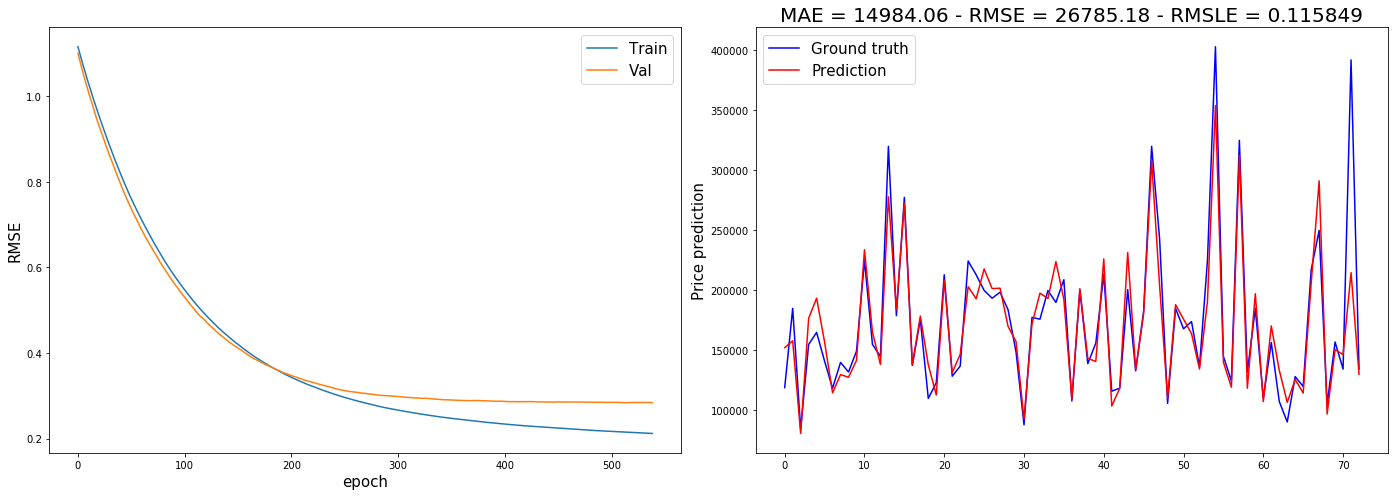

In [18]:
reg = xgb.XGBRegressor(**params_xgb).fit(X_train,
                                         y_train,
                                         early_stopping_rounds = 25,
                                         eval_metric = ['rmse'],
                                         eval_set = [(X_train, y_train), (X_val, y_val)],
                                         verbose = False)
# Test data
preds, gt, index = mockup_skew.decode(reg.predict(X_test), y_test)
mae = mean_absolute_error(preds, gt)
rmsle = np.sqrt(mean_squared_log_error(preds, gt))
rmse = np.sqrt(mean_squared_error(preds, gt))

# Training metrics
results = reg.evals_result()
# print(results['validation_0'])
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(gt,'b-', label='Ground truth')
ax2.plot(preds,'r-', label='Prediction')
ax2.set_ylabel('Price prediction', fontsize=15)
ax2.set_title('MAE = %.2f - RMSE = %.2f - RMSLE = %.6f'%(mae, rmse, rmsle), fontsize=20)
ax2.legend(fontsize=15)

plt.tight_layout()
plt.show()

# Kurtosis check

In [19]:
train = pd.concat([X_train, y_train],axis=1)

0.3541037944706007


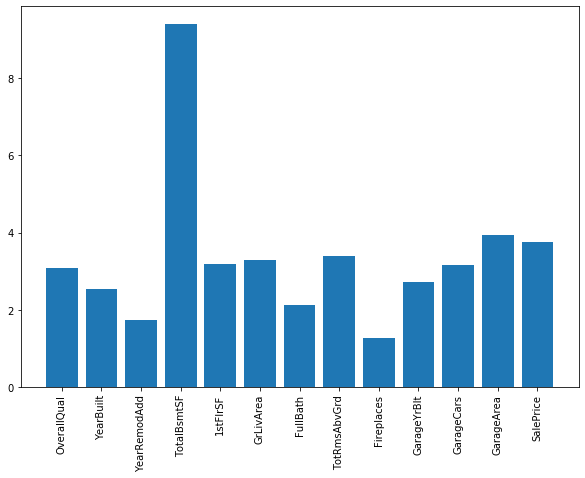

In [20]:
kurt = {}
col = [i for i in train.columns if 'x' not in i]
for i in col:
    kurt[i] = stats.kurtosis(train.loc[:,i], fisher=False)
kurt_mean_ref = np.mean(list(kurt.values()))-3
# kurt_mean_ref = kurt['TotalBsmtSF'] - 3
print(kurt_mean_ref)

plt.figure(figsize=(10,7))
plt.bar(kurt.keys(), kurt.values())
plt.xticks(rotation=90)
plt.show()

In [25]:
removed_row = []
for idx in feature.index:
    df_kurt = train.loc[[i for i in df.index if i!=idx],:]
    kurt = {}
    for i in col:
        kurt[i] = stats.kurtosis(df_kurt.loc[:,i], fisher=False)
    kurt_mean = np.mean(list(kurt.values()))-3
#     kurt_mean = kurt['TotalBsmtSF'] - 3
    if abs(kurt_mean)<abs(kurt_mean_ref):
        kurt_mean_ref = kurt_mean
        removed_row.append(idx)
        train = df.drop([idx])
print(len(removed_row))
train.head()

0


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,x0_C (all),x0_FV,x0_RH,x0_RL,x0_RM,x1_Grvl,x1_Pave,x2_IR1,x2_IR2,x2_IR3,x2_Reg,x3_Bnk,x3_HLS,x3_Low,x3_Lvl,x4_AllPub,x4_NoSeWa,x5_Corner,x5_CulDSac,x5_FR2,x5_FR3,x5_Inside,x6_Gtl,x6_Mod,x6_Sev,x7_Blmngtn,x7_Blueste,x7_BrDale,x7_BrkSide,x7_ClearCr,x7_CollgCr,x7_Crawfor,x7_Edwards,x7_Gilbert,x7_IDOTRR,x7_MeadowV,x7_Mitchel,x7_NAmes,x7_NPkVill,x7_NWAmes,x7_NoRidge,x7_NridgHt,x7_OldTown,x7_SWISU,x7_Sawyer,x7_SawyerW,x7_Somerst,x7_StoneBr,x7_Timber,x7_Veenker,x8_Artery,x8_Feedr,x8_Norm,x8_PosA,x8_PosN,x8_RRAe,x8_RRAn,x8_RRNe,x8_RRNn,x9_Artery,x9_Feedr,x9_Norm,x9_PosA,x9_PosN,x9_RRAe,x9_RRAn,x9_RRNn,x10_1Fam,x10_2fmCon,x10_Duplex,x10_Twnhs,x10_TwnhsE,x11_1.5Fin,x11_1.5Unf,x11_1Story,x11_2.5Fin,x11_2.5Unf,x11_2Story,x11_SFoyer,x11_SLvl,x12_Flat,x12_Gable,x12_Gambrel,x12_Hip,x12_Mansard,x12_Shed,x13_ClyTile,x13_CompShg,x13_Membran,x13_Metal,x13_Roll,x13_Tar&Grv,x13_WdShake,x13_WdShngl,x14_AsbShng,x14_AsphShn,x14_BrkComm,x14_BrkFace,x14_CBlock,x14_CemntBd,x14_HdBoard,x14_ImStucc,x14_MetalSd,x14_Plywood,x14_Stone,x14_Stucco,x14_VinylSd,x14_Wd Sdng,x14_WdShing,x15_AsbShng,x15_AsphShn,x15_Brk Cmn,x15_BrkFace,x15_CBlock,x15_CmentBd,x15_HdBoard,x15_ImStucc,x15_MetalSd,x15_Other,x15_Plywood,x15_Stone,x15_Stucco,x15_VinylSd,x15_Wd Sdng,x15_Wd Shng,x16_BrkCmn,x16_BrkFace,x16_None,x16_Stone,x16_nan,x17_Ex,x17_Fa,x17_Gd,x17_TA,x18_Ex,x18_Fa,x18_Gd,x18_Po,x18_TA,x19_BrkTil,x19_CBlock,x19_PConc,x19_Slab,x19_Stone,x19_Wood,x20_Ex,x20_Fa,x20_Gd,x20_TA,x20_nan,x21_Fa,x21_Gd,x21_Po,x21_TA,x21_nan,x22_Av,x22_Gd,x22_Mn,x22_No,x22_nan,x23_ALQ,x23_BLQ,x23_GLQ,x23_LwQ,x23_Rec,x23_Unf,x23_nan,x24_ALQ,x24_BLQ,x24_GLQ,x24_LwQ,x24_Rec,x24_Unf,x24_nan,x25_Floor,x25_GasA,x25_GasW,x25_Grav,x25_OthW,x25_Wall,x26_Ex,x26_Fa,x26_Gd,x26_Po,x26_TA,x27_N,x27_Y,x28_FuseA,x28_FuseF,x28_FuseP,x28_Mix,x28_SBrkr,x28_nan,x29_Ex,x29_Fa,x29_Gd,x29_TA,x30_Maj1,x30_Maj2,x30_Min1,x30_Min2,x30_Mod,x30_Sev,x30_Typ,x31_Ex,x31_Fa,x31_Gd,x31_Po,x31_TA,x31_nan,x32_2Types,x32_Attchd,x32_Basment,x32_BuiltIn,x32_CarPort,x32_Detchd,x32_nan,x33_Fin,x33_RFn,x33_Unf,x33_nan,x34_Ex,x34_Fa,x34_Gd,x34_Po,x34_TA,x34_nan,x35_Ex,x35_Fa,x35_Gd,x35_Po,x35_TA,x35_nan,x36_N,x36_P,x36_Y,x37_COD,x37_CWD,x37_Con,x37_ConLD,x37_ConLI,x37_ConLw,x37_New,x37_Oth,x37_WD,x38_Abnorml,x38_AdjLand,x38_Alloca,x38_Family,x38_Normal,x38_Partial,SalePrice
930,1.374324,1.183071,1.072115,0.869360,0.890027,0.067395,0.789470,0.396903,-1.032599,1.187511,1.649742,0.640864,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.468164
656,-0.794879,-0.406180,1.023678,0.111174,-0.151544,-0.924576,-1.025689,-0.945865,-1.032599,-0.812940,-1.026506,-0.752930,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-0.340767
45,2.097391,1.116853,0.975241,1.332773,1.451122,0.601771,0.789470,-0.226360,0.803032,1.104159,0.311618,0.481841,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0

nan


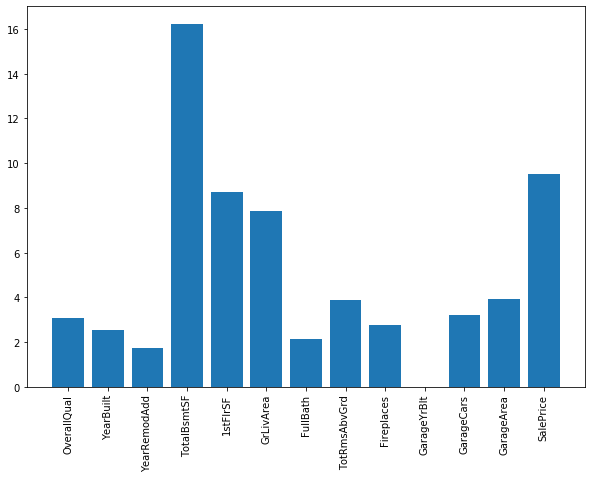

In [22]:
kurt = {}
for i in col:
    kurt[i] = stats.kurtosis(df.loc[:,i], fisher=False)
kurt_mean_ref = np.mean(list(kurt.values()))-3
print(kurt_mean_ref)

plt.figure(figsize=(10,7))
plt.bar(kurt.keys(), kurt.values())
plt.xticks(rotation=90)
plt.show()

In [23]:
X_train = train[train_col]
y_train = train[target]

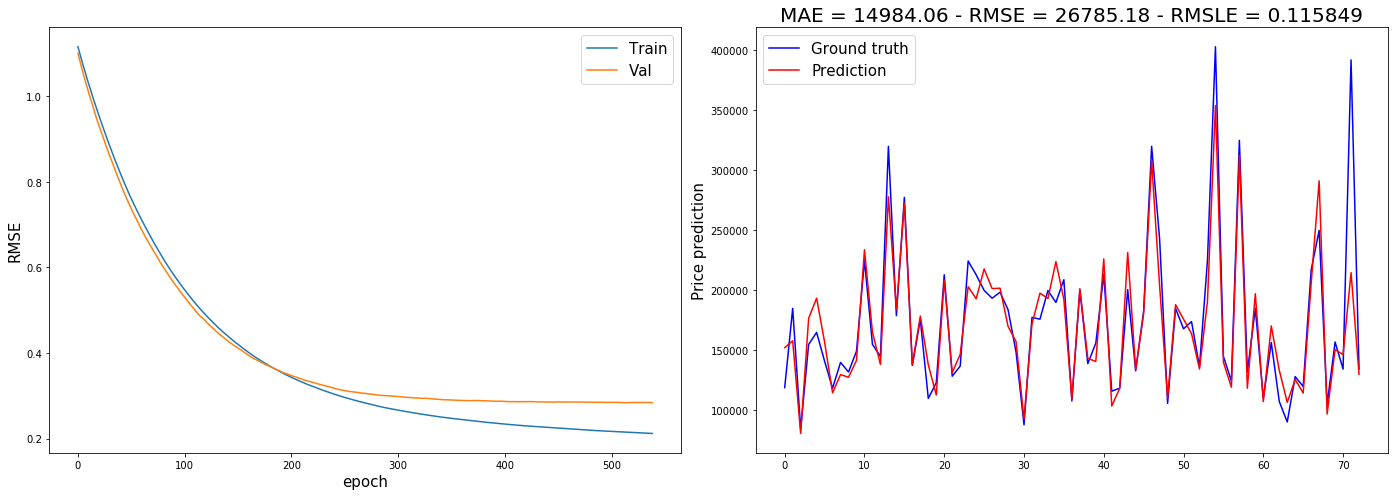

In [24]:
reg = xgb.XGBRegressor(**params_xgb).fit(X_train,
                                         y_train,
                                         early_stopping_rounds = 25,
                                         eval_metric = ['rmse'],
                                         eval_set = [(X_train, y_train), (X_val, y_val)],
                                         verbose = False)
# Test data
preds, gt, index = mockup_skew.decode(reg.predict(X_test), y_test)
mae = mean_absolute_error(preds, gt)
rmsle = np.sqrt(mean_squared_log_error(preds, gt))
rmse = np.sqrt(mean_squared_error(preds, gt))

# Training metrics
results = reg.evals_result()
# print(results['validation_0'])
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot log loss
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax1.set_xlabel('epoch', fontsize=15)
ax1.set_ylabel('RMSE', fontsize=15)
ax1.legend(fontsize=15)

ax2.plot(gt,'b-', label='Ground truth')
ax2.plot(preds,'r-', label='Prediction')
ax2.set_ylabel('Price prediction', fontsize=15)
ax2.set_title('MAE = %.2f - RMSE = %.2f - RMSLE = %.6f'%(mae, rmse, rmsle), fontsize=20)
ax2.legend(fontsize=15)

plt.tight_layout()
plt.show()